In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import os
from os.path import isfile, join


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

import copy
import seaborn as sns
import requests
import json

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.colors as mcolors

In [3]:
result = pd.read_csv('result.csv')

## Forecasting model

In [4]:
X = result[result.columns.drop(['ydel_saldo','oktmo', 'name', 'popsize'])]
Y = result[['ydel_saldo']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = RFR(n_estimators =500, min_samples_split =2, min_samples_leaf = 1, max_features = 'sqrt', random_state=24)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")
print(f"Mean Absolute Error (MAE): {mae}")

Train score: 0.9391226621349358
Test score: 0.5912037820849224
Mean Absolute Error (MAE): 0.008913730016477028


C:\Users\user\AppData\Local\Temp\ipykernel_3748\3304966327.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_features['factors'] = top_5_features['factors'].replace(old_value, new_value)


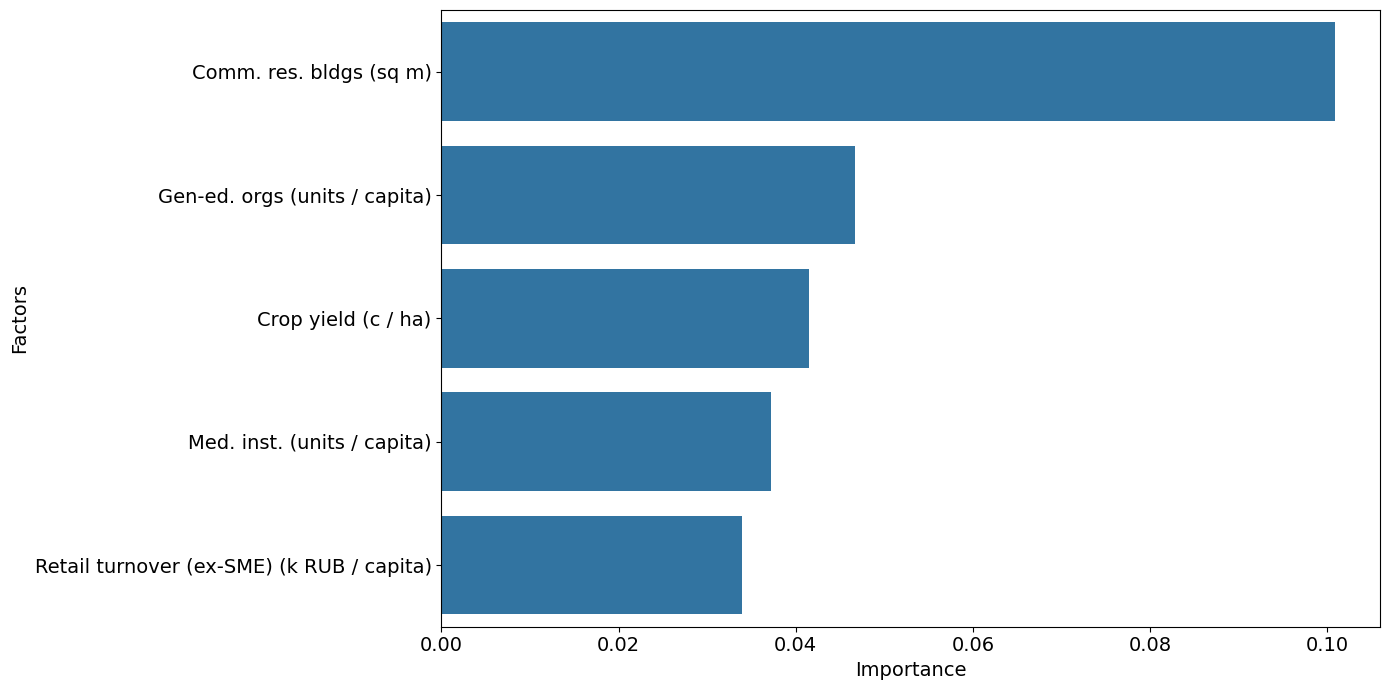

In [5]:
feature_imp = pd.DataFrame({'importance': model.feature_importances_, 'factors':X.columns})
feature_imp = feature_imp.sort_values(by='importance', ascending=False)

top_5_features = feature_imp.head(5)

replacements = {
    'consnewareas':  'Comm. res. bldgs (sq m)',
    'schoolnum':     'Gen-ed. orgs (units / capita)',
    'harvest':       'Crop yield (c / ha)',
    'hospitals':     'Med. inst. (units / capita)',
    'retailturnover':'Retail turnover (ex-SME) (k RUB / capita)'
}
for old_value, new_value in replacements.items():
    top_5_features['factors'] = top_5_features['factors'].replace(old_value, new_value)

final_feature_imp = pd.concat([top_5_features])


plt.figure(figsize=(14, 7))
ax = sns.barplot(x="importance", y="factors", data=final_feature_imp)

ax.set_xlabel("Importance", fontsize=14)
ax.set_ylabel("Factors",   fontsize=14)


ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.savefig('fig1.png', dpi=600)
plt.show()


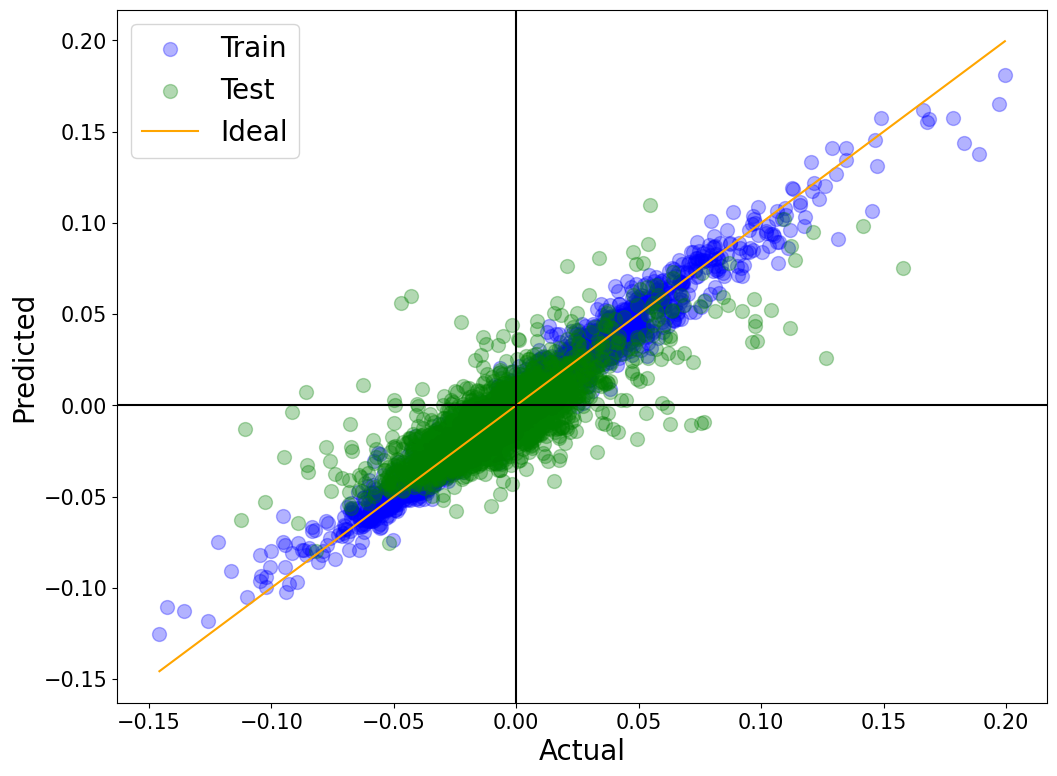

In [6]:
scale = np.linspace(y_train.min(), y_train.max(), 100)

plt.figure(figsize=(12,9))
plt.scatter(y_train, model.predict(X_train) * 1.2,
            c='b', alpha=.3, label='Train', s=100)
plt.scatter(y_test,  model.predict(X_test)  * 1.2,
            c='g', alpha=.3, label='Test', s=100)
plt.plot(scale, scale, c='orange', label='Ideal')

plt.axhline(0, c='k')
plt.axvline(0, c='k')

plt.xlabel('Actual',   fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)

plt.savefig('fig2.png', dpi=600)
plt.show()


In [7]:
top = mpl.colormaps['Reds'].resampled(128)
bottom = mpl.colormaps['Greens'].resampled(128)

newcolors = np.vstack((top(np.linspace(1, 0, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='GreenRed')

## Feature importance

In [8]:
feature_importance = model.feature_importances_

importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance = importance.sort_values(by='Importance', ascending=False)
f_i = importance.copy()
f_i.index = f_i.Feature
f_i = f_i.Importance
f_i

Feature
consnewareas             0.100919
schoolnum                0.046702
harvest                  0.041501
hospitals                0.037218
retailturnover           0.033918
avgemployers             0.030901
socialaidcenters         0.027405
beforeschool             0.026907
sportschool              0.023464
roadslen                 0.023073
livarea                  0.022727
sportsvenue              0.022654
museums                  0.022453
livestock                0.022064
foodservturnover         0.021255
invest                   0.020768
consnewapt               0.019593
factoriescap             0.019581
avgsalary                0.019152
library                  0.019009
goodcompincome           0.018988
agrprod                  0.018940
foodseats                0.018818
cliniccap                0.018692
badhousesdwellers        0.018058
pollutionvol             0.017720
musartschool             0.017586
budincome                0.017527
visiblecompanies         0.017422
goodco

## Values - identities table

In [11]:
f_i.loc['badcompanies'] = -1 * f_i.loc['badcompanies']
f_i.loc['badhousesdwellers'] = -1 * f_i.loc['badhousesdwellers']
f_i.loc['pollutionvol'] = -1 * f_i.loc['pollutionvol']

comm_soc = dict()
cs_sum = f_i[f_i.index.isin(['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                             'cliniccap', 'docsnum'])].sum()
for indicator in ['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                  'cliniccap', 'docsnum']:
    comm_soc[indicator] = f_i.loc[indicator] / cs_sum

comm_soc

In [13]:
comm_base = dict()
cb_sum = f_i[f_i.index.isin(['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                             'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc'])].sum()
for indicator in ['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                  'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc']:
    comm_base[indicator] = f_i.loc[indicator] / cb_sum

comm_base

In [15]:
s_work_soc = dict()
sws_sum = f_i[f_i.index.isin(['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                              'cliniccap', 'docsnum',
                              'livestock', 'harvest', 'agrprod', 'factoriescap', 'avgemployers', 'avgsalary',
                              'goodcompanies', 'visiblecompanies', 'goodcompincome', 'foodseats', 'foodservturnover', 'cinemas'])].sum()
for indicator in ['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                  'cliniccap', 'docsnum',
                  'livestock', 'harvest', 'agrprod', 'factoriescap', 'avgemployers', 'avgsalary',
                  'goodcompanies', 'visiblecompanies', 'goodcompincome', 'foodseats', 'foodservturnover', 'cinemas']:
    s_work_soc[indicator] = f_i.loc[indicator] / sws_sum

s_work_soc

{'shoparea': 0.038560859816072254,
 'retailturnover': 0.07627792509059003,
 'sportsvenue': 0.05094728413579402,
 'roadslen': 0.0518882800583089,
 'invest': 0.046704368639090235,
 'hospitals': 0.0836987762403014,
 'cliniccap': 0.0420376395221087,
 'docsnum': 0.03585318828256228,
 'livestock': 0.04961971384514937,
 'harvest': 0.09333164023011885,
 'agrprod': 0.04259368597071025,
 'factoriescap': 0.04403658555348437,
 'avgemployers': 0.06949250627089801,
 'avgsalary': 0.04307186600813324,
 'goodcompanies': 0.03910730873589858,
 'visiblecompanies': 0.03918076501735632,
 'goodcompincome': 0.042702704767674245,
 'foodseats': 0.04232084992924012,
 'foodservturnover': 0.04779989987243383,
 'cinemas': 0.020774152014075037}

In [16]:
s_work_base = dict()
swb_sum = f_i[f_i.index.isin(['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                              'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc',
                              'badcompanies'])].sum()
for indicator in ['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                  'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc',
                  'badcompanies']:
    s_work_base[indicator] = f_i.loc[indicator] / swb_sum

s_work_base

{'livarea': 0.384806219845108,
 'servicesnum': 0.2891455014823725,
 'budincome': 0.29675971169681264,
 'pollutionvol': -0.30002758260812773,
 'litstreetperc': 0.2689779452887332,
 'munipoliceworkers': 0.11564471559107435,
 'pollutcapturedperc': 0.2358821967502256,
 'badcompanies': -0.2911887080461987}

In [17]:
s_old_dev = {'library': np.float64(1)}

s_old_dev

{'library': 1.0}

In [18]:
s_old_soc = dict()
sos_sum = f_i[f_i.index.isin(['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                              'cliniccap', 'docsnum',
                               'socialaidhomeservices'])].sum()# 'socialaidcenterscap',
# 'socialaidcenterscap',
for indicator in ['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                  'cliniccap', 'docsnum', 'socialaidhomeservices']:
    s_old_soc[indicator] = f_i.loc[indicator] / sos_sum

s_old_soc

{'shoparea': 0.08337586179074785,
 'retailturnover': 0.16492728041783183,
 'sportsvenue': 0.11015765055501797,
 'roadslen': 0.11219226146243755,
 'invest': 0.10098366590502969,
 'hospitals': 0.18097256215634128,
 'cliniccap': 0.09089331616365445,
 'docsnum': 0.07752136454588675,
 'socialaidhomeservices': 0.07897603700305272}

In [19]:
s_old_base = copy.deepcopy(comm_base)

s_old_base

{'livarea': 0.2980247716287646,
 'servicesnum': 0.22393744592136486,
 'budincome': 0.22983450044716056,
 'pollutionvol': -0.23236540153927118,
 'litstreetperc': 0.20831807435471256,
 'munipoliceworkers': 0.08956453450252494,
 'pollutcapturedperc': 0.18268607468474374}

In [20]:
s_par_dev = dict()
spd_sum = f_i[f_i.index.isin(['library', 'musartschool', 'sportschool', 'beforeschool', 'schoolnum'])].sum()
for indicator in ['library', 'musartschool', 'sportschool', 'beforeschool', 'schoolnum']:
    s_par_dev[indicator] = f_i.loc[indicator] / spd_sum

s_par_dev

{'library': 0.14221126496095102,
 'musartschool': 0.13156201385486863,
 'sportschool': 0.17553762229450037,
 'beforeschool': 0.2012987158524519,
 'schoolnum': 0.3493903830372281}

In [21]:
s_par_soc = dict()
sps_sum = f_i[f_i.index.isin(['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                              'cliniccap', 'docsnum',
                              'livestock', 'harvest', 'agrprod', 'factoriescap', 'avgemployers', 'avgsalary',
                              'goodcompanies', 'visiblecompanies', 'goodcompincome', 'foodseats', 'foodservturnover',
                              'zoos', 'circuses', 'cinemas'])].sum()
for indicator in ['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                  'cliniccap', 'docsnum',
                  'livestock', 'harvest', 'agrprod', 'factoriescap', 'avgemployers', 'avgsalary',
                  'goodcompanies', 'visiblecompanies', 'goodcompincome', 'foodseats', 'foodservturnover',
                  'zoos', 'circuses', 'cinemas']:
    s_par_soc[indicator] = f_i.loc[indicator] / sps_sum

s_par_soc

{'shoparea': 0.0384536013230582,
 'retailturnover': 0.07606575515105861,
 'sportsvenue': 0.0508055723340959,
 'roadslen': 0.051743950840789074,
 'invest': 0.04657445866765039,
 'hospitals': 0.08346596492205083,
 'cliniccap': 0.04192071023457424,
 'docsnum': 0.03575346128053797,
 'livestock': 0.04948169473052887,
 'harvest': 0.09307203473560027,
 'agrprod': 0.04247521001890515,
 'factoriescap': 0.04391409612180468,
 'avgemployers': 0.06929921023097725,
 'avgsalary': 0.042952059980431286,
 'goodcompanies': 0.03899853027450391,
 'visiblecompanies': 0.03907178223453082,
 'goodcompincome': 0.042583925575953634,
 'foodseats': 0.04220313288122471,
 'foodservturnover': 0.04766694263934841,
 'zoos': 0.001788814238549372,
 'circuses': 0.0009927236609077253,
 'cinemas': 0.020716367922918807}

In [22]:
s_par_base = dict()
spb_sum = f_i[f_i.index.isin(['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                              'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc',
                              'badcompanies', 'consnewareas', 'consnewapt'])].sum()
for indicator in ['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                  'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc',
                  'badcompanies', 'consnewareas', 'consnewapt']:
    s_par_base[indicator] = f_i.loc[indicator] / spb_sum
s_par_base

{'livarea': 0.12656178829483472,
 'servicesnum': 0.09509922100465518,
 'budincome': 0.09760351540400307,
 'pollutionvol': -0.09867830984630492,
 'litstreetperc': 0.08846616299839173,
 'munipoliceworkers': 0.038035253218997554,
 'pollutcapturedperc': 0.07758105536765826,
 'badcompanies': -0.09577122645372944,
 'consnewareas': 0.5619954637058961,
 'consnewapt': 0.10910707630559745}

In [23]:
loc_dev = {'museums': f_i.loc['museums'] / (f_i.loc['museums'] + f_i.loc['naturesecure']),
           'naturesecure': f_i.loc['naturesecure'] / (f_i.loc['museums'] + f_i.loc['naturesecure'])}
loc_dev

{'museums': 0.5961806121750922, 'naturesecure': 0.4038193878249078}

In [24]:
ls_sum = f_i[f_i.index.isin(['cultureorg', 'parks', 'theatres'])].sum()
loc_soc = {'cultureorg': f_i.loc['cultureorg'] / ls_sum, 'parks': f_i.loc['parks'] / ls_sum, 'theatres': f_i.loc['theatres'] / ls_sum}
loc_soc

{'cultureorg': 0.6450666496607945,
 'parks': 0.2575581376663041,
 'theatres': 0.0973752126729015}

In [25]:
loc_base = {'badhousesdwellers': np.float64(-1)}

grid_coeffs = {'comm': {'soc': comm_soc, 'bas': comm_base},
               'soc_workers': {'soc': s_work_soc, 'bas': s_work_base},
               'soc_old': {'dev': s_old_dev, 'soc': s_old_soc, 'bas': s_old_base},
               'soc_parents': {'dev': s_par_dev, 'soc': s_par_soc, 'bas': s_par_base},
               'loc': {'dev': loc_dev, 'soc': loc_soc, 'bas': loc_base}}

In [26]:
with open('grid_coeffs.json', 'w') as outfile:
    json.dump(grid_coeffs, outfile)

In [27]:
pd.DataFrame(grid_coeffs).reindex(['dev', 'soc', 'bas'])

,comm,soc_workers,soc_old,soc_parents,loc
dev,NaN,NaN,{'library': 1.0},"{'library': 0.14221126496095102, 'musartschool...","{'museums': 0.5961806121750922, 'naturesecure'..."
soc,"{'shoparea': 0.09052518190672114, 'retailturno...","{'shoparea': 0.038560859816072254, 'retailturn...","{'shoparea': 0.08337586179074785, 'retailturno...","{'shoparea': 0.0384536013230582, 'retailturnov...","{'cultureorg': 0.6450666496607945, 'parks': 0...."
bas,"{'livarea': 0.2980247716287646, 'servicesnum':...","{'livarea': 0.384806219845108, 'servicesnum': ...","{'livarea': 0.2980247716287646, 'servicesnum':...","{'livarea': 0.12656178829483472, 'servicesnum'...",{'badhousesdwellers': -1.0}


In [28]:
def loc_counts(loc_data, grid_coeffs):
    n_coeffs = copy.deepcopy(grid_coeffs)
    for col in grid_coeffs.keys():
        for row in grid_coeffs[col].keys():
            cell_sum = 0
            for indicator in grid_coeffs[col][row].keys():
                value = loc_data.get(indicator, 0)
                if pd.isna(value):
                    value = 0
                cell_sum += value * grid_coeffs[col][row][indicator]
            n_coeffs[col][row] = cell_sum
    return pd.DataFrame(n_coeffs).reindex(['dev', 'soc', 'bas'])

def tab_to_ser(df, loc = None):
    sr = pd.Series(df.values.flatten(), index = ['comm_dev', 'soc_workers_dev', 'soc_old_dev', 'soc_parents_dev', 'loc_dev',
                                                 'comm_soc', 'soc_workers_soc', 'soc_old_soc', 'soc_parents_soc', 'loc_soc',
                                                 'comm_base', 'soc_workers_base', 'soc_old_base', 'soc_parents_base', 'loc_base'])
    if loc:
        sr.name = loc
    return sr

### Select year

In [29]:
result_norm = result[(result.year ==2022)]
result_norm.loc[result_norm['name'] == 'Муниципальный округ Надымский район', 'theatres'] = 1 / result_norm.loc[result_norm['name'] == 'Муниципальный округ Надымский район', 'popsize']
# Exclude the 'year' and 'oktmo' columns from normalization and coloring
columns_to_normalize = [col for col in result_norm.columns if col not in ['oktmo', 'year','ydel_saldo','name' ]]
result_norm[columns_to_normalize] = (result_norm[columns_to_normalize] - result_norm[columns_to_normalize].min()) / (result_norm[columns_to_normalize].max() - result_norm[columns_to_normalize].min())

C:\Users\user\AppData\Local\Temp\ipykernel_3748\71302913.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_norm[columns_to_normalize] = (result_norm[columns_to_normalize] - result_norm[columns_to_normalize].min()) / (result_norm[columns_to_normalize].max() - result_norm[columns_to_normalize].min())


In [30]:
def calculate_loc_counts(row):
    loc_data = loc_counts(row, grid_coeffs)
    loc_series = tab_to_ser(loc_data, row.name)
    loc_series['oktmo'] = row['oktmo']
    loc_series['year'] = row['year']
    loc_series['ydel_saldo'] = row['ydel_saldo']
    return loc_series

full_df = result_norm.apply(calculate_loc_counts, axis=1)
full_df['year'] = pd.to_numeric(full_df['year'], errors='coerce').astype('Int64')
full_df['oktmo'] = pd.to_numeric(full_df['oktmo'], errors='coerce').astype('Int64')

## Choose the territory (Nadym)

In [31]:
rez = result_norm
rez['year'] = pd.to_numeric(rez['year'], errors='coerce').astype('Int64')
rez['oktmo'] = pd.to_numeric(rez['oktmo'], errors='coerce').astype('Int64')
rez=rez[(rez.oktmo >= 71900000) & (rez.oktmo < 72000000)]

C:\Users\user\AppData\Local\Temp\ipykernel_3748\583980863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez['year'] = pd.to_numeric(rez['year'], errors='coerce').astype('Int64')
C:\Users\user\AppData\Local\Temp\ipykernel_3748\583980863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez['oktmo'] = pd.to_numeric(rez['oktmo'], errors='coerce').astype('Int64')


In [32]:
lo_tab = full_df[(full_df.oktmo >= 71000000) & (full_df.oktmo < 72000000)& (full_df.year ==2022)]
lo_tab

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base,oktmo,year,ydel_saldo
16114,NaN,NaN,0.503621,0.204588,0.000818,0.212834,0.107010,0.196680,0.106713,0.013478,0.233256,0.269408,0.233256,0.091801,-0.060357,71613000,2022,-0.016800
16143,NaN,NaN,0.343712,0.305760,0.058298,0.160450,0.094067,0.148315,0.093805,0.355279,0.255706,0.304589,0.255706,0.102992,-0.300360,71624000,2022,0.006514
16155,NaN,NaN,0.338469,0.138493,0.001437,0.205438,0.107497,0.189673,0.107198,0.008745,0.237128,0.301375,0.237128,0.101797,-0.027382,71626000,2022,-0.002976
16167,NaN,NaN,0.019114,0.114415,0.068160,0.104333,0.064278,0.096723,0.064099,0.012809,0.202421,0.231199,0.202421,0.077372,-0.054322,71630000,2022,0.002513
16179,NaN,NaN,0.368211,0.367707,0.064499,0.171601,0.096821,0.158646,0.096552,0.012219,0.293719,0.348810,0.293719,0.123020,-0.148947,71632000,2022,0.016282
16191,NaN,NaN,0.022510,0.137924,0.000896,0.145410,0.078296,0.134660,0.078078,0.060169,0.314886,0.368445,0.314886,0.122529,-0.059006,71634000,2022,-0.004623
16223,NaN,NaN,0.019857,0.163483,0.003227,0.289422,0.147251,0.267214,0.146842,0.013269,0.139681,0.161372,0.139681,0.056160,-0.151909,71642000,2022,-0.002808
16235,NaN,NaN,0.003556,0.116244,0.002770,0.089375,0.075072,0.082551,0.074863,0.016922,0.295640,0.360933,0.295640,0.151317,-0.033428,71644000,2022,0.029833
16247,NaN,NaN,0.021961,0.209402,0.116537,0.169525,0.128135,0.156860,0.127779,0.014796,0.285817,0.321673,0.285817,0.110966,-0.060654,71648000,2022,0.000547
16259,NaN,NaN,0.348888,0.211772,0.000789,0.214480,0.125154,0.198206,0.124806,0.013445,0.268786,0.313381,0.268786,0.104973,-0.005573,71650000,2022,-0.001989


In [33]:
columns_to_normalize = [col for col in lo_tab.columns if col not in ['oktmo', 'year','ydel_saldo' ]]

nlo_tab = lo_tab.copy()
nlo_tab[columns_to_normalize] = nlo_tab[columns_to_normalize].apply(lambda s: (s - s.min()) / (s.max() - s.min()), axis=0)

def color_cols_custom(s):
    if s.name in ['oktmo', 'year','ydel_saldo']:
        return [''] * len(s)
    better = s >= s.mean()
    return ['background-color: green' if v else 'background-color: red' for v in better]

nlo_tab.style.apply(color_cols_custom, axis=0)

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base,oktmo,year,ydel_saldo
16114,nan,nan,0.861312,0.337293,0.000059,0.639907,0.279837,0.640484,0.279837,0.037936,0.195000,0.210533,0.195000,0.211920,0.919828,71613000,2022,-0.016800
16143,nan,nan,0.587830,0.627915,0.117160,0.393621,0.215645,0.393967,0.215645,1.000000,0.241783,0.279090,0.241783,0.278459,0.601035,71624000,2022,0.006514
16155,nan,nan,0.578863,0.147430,0.001320,0.605136,0.282249,0.604773,0.282249,0.024615,0.203069,0.272827,0.203069,0.271354,0.963628,71626000,2022,-0.002976
16167,nan,nan,0.032690,0.078263,0.137252,0.129779,0.067912,0.131002,0.067912,0.036054,0.130743,0.136073,0.130743,0.126127,0.927845,71630000,2022,0.002513
16179,nan,nan,0.629729,0.805865,0.129795,0.446047,0.229306,0.446628,0.229306,0.034393,0.320999,0.365265,0.320999,0.397546,0.802156,71632000,2022,0.016282
16191,nan,nan,0.038498,0.145795,0.000219,0.322905,0.137430,0.324368,0.137430,0.169357,0.365108,0.403529,0.365108,0.394627,0.921623,71634000,2022,-0.004623
16223,nan,nan,0.033961,0.219214,0.004967,1.000000,0.479405,1.000000,0.479405,0.037348,0.000000,0.000000,0.000000,0.000000,0.798220,71642000,2022,-0.002808
16235,nan,nan,0.006081,0.083517,0.004037,0.059451,0.121444,0.058767,0.121444,0.047630,0.325001,0.388889,0.325001,0.565799,0.955598,71644000,2022,0.029833
16247,nan,nan,0.037558,0.351120,0.235808,0.436287,0.384602,0.437523,0.384602,0.041646,0.304531,0.312383,0.304531,0.325872,0.919435,71648000,2022,0.000547
16259,nan,nan,0.596682,0.357929,0.000000,0.647649,0.369819,0.648265,0.369819,0.037843,0.269042,0.296223,0.269042,0.290237,0.992597,71650000,2022,-0.001989


In [37]:
#nlo_tab = nlo_tab[nlo_tab.columns.drop(['ydel_saldo','oktmo', 'year'])]
sb_tab = loc_counts(rez.loc[16653], grid_coeffs)
sb_tab

,comm,soc_workers,soc_old,soc_parents,loc
dev,NaN,NaN,0.019645,0.197017,0.084357
soc,0.144638,0.125879,0.133430,0.125529,0.034302
bas,0.289001,0.358350,0.289001,0.118664,0.000000


In [36]:
sb = nlo_tab.loc[16653]
sb

comm_dev                 NaN
soc_workers_dev          NaN
soc_old_dev         0.033598
soc_parents_dev     0.315544
loc_dev             0.170250
comm_soc            0.319275
soc_workers_soc     0.373411
soc_old_soc         0.318099
soc_parents_soc     0.373411
loc_soc             0.096550
comm_base           0.311167
soc_workers_base    0.383856
soc_old_base        0.311167
soc_parents_base    0.371645
loc_base            1.000000
Name: 16653, dtype: float64

In [38]:
for i in sb_tab.index:
    # Replace 'bas' with 'base'
    row_name = 'base' if i == 'bas' else i
    for j in sb_tab.columns:
        sb_tab.loc[i, j] = sb.loc[f'{j}_{row_name}']

In [39]:
sb_tab

,comm,soc_workers,soc_old,soc_parents,loc
dev,NaN,NaN,0.033598,0.315544,0.17025
soc,0.319275,0.373411,0.318099,0.373411,0.09655
bas,0.311167,0.383856,0.311167,0.371645,1.00000


In [40]:
plt.rcParams.update({'font.size':  10  })

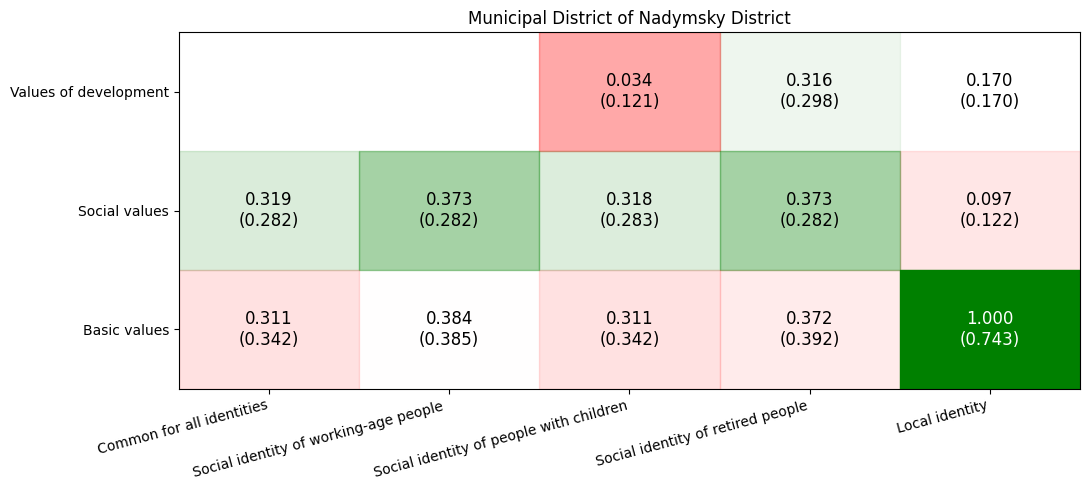

In [41]:
means = {}
for col in ['comm', 'soc_workers', 'soc_old', 'soc_parents', 'loc']:
    for row in ['dev', 'soc', 'base']:
        row_name = 'bas' if row == 'base' else row
        column_name = f'{col}_{row}'
        means[(row_name, col)] = nlo_tab[column_name].mean()

column_names = {
    'comm': 'Common for all identities',
    'soc_workers': 'Social identity of working-age people ',
    'soc_old': 'Social identity of people with children',
    'soc_parents': 'Social identity of retired people',
    'loc': 'Local identity'
}

row_names = {
    'dev': 'Values of development',
    'soc': 'Social values',
    'bas': 'Basic values'
}

sb_tab_renamed = sb_tab.copy()
sb_tab_renamed.index = [row_names[i] for i in sb_tab.index]
sb_tab_renamed.columns = [column_names[c] for c in sb_tab.columns]


values = np.zeros_like(sb_tab_renamed, dtype=float)
annotations = np.empty_like(sb_tab_renamed, dtype=object)
colors = np.empty_like(sb_tab_renamed, dtype=object)

max_diff = 0

for i, orig_i in zip(sb_tab_renamed.index, sb_tab.index):
    for j, orig_j in zip(sb_tab_renamed.columns, sb_tab.columns):
        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            val = sb_tab.loc[orig_i, orig_j]
            mean_val = means[(orig_i, orig_j)]
            diff = abs(val - mean_val)
            max_diff = max(max_diff, diff)

def get_color(val, mean_val, max_diff):
    diff = val - mean_val
    intensity = min(abs(diff) / max_diff, 1.0)
    if diff >= 0:
        return mcolors.to_rgba('green', intensity)
    else:
        return mcolors.to_rgba('red', intensity)

for i, orig_i in zip(sb_tab_renamed.index, sb_tab.index):
    for j, orig_j in zip(sb_tab_renamed.columns, sb_tab.columns):
        idx_i = sb_tab_renamed.index.get_loc(i)
        idx_j = sb_tab_renamed.columns.get_loc(j)

        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            val = sb_tab.loc[orig_i, orig_j]
            mean_val = means[(orig_i, orig_j)]
            values[idx_i, idx_j] = val
            annotations[idx_i, idx_j] = f'{val:.3f}\n({mean_val:.3f})'
            colors[idx_i, idx_j] = get_color(val, mean_val, max_diff)
        else:
            values[idx_i, idx_j] = np.nan
            annotations[idx_i, idx_j] = 'NaN'
            colors[idx_i, idx_j] = mcolors.to_rgba('white', 1.0)


plt.figure(figsize=(11, 5))


for i in range(len(sb_tab_renamed.index)):
    for j in range(len(sb_tab_renamed.columns)):
        if not np.isnan(values[i, j]):
            plt.fill_between([j, j+1], [i, i], [i+1, i+1], color=colors[i, j])

            plt.text(j + 0.5, i + 0.5, annotations[i, j],
                    ha='center', va='center', fontsize=12,
                    color='black' if mcolors.to_rgba(colors[i, j])[3] < 0.5 else 'white')


plt.ylim(len(sb_tab_renamed.index), 0)
plt.xlim(0, len(sb_tab_renamed.columns))
plt.xticks(np.arange(len(sb_tab_renamed.columns)) + 0.5, sb_tab_renamed.columns, rotation=15, ha='right')
plt.yticks(np.arange(len(sb_tab_renamed.index)) + 0.5, sb_tab_renamed.index)

plt.title('Municipal District of Nadymsky District')
plt.tight_layout()
plt.show()

## Another territory

In [42]:
result_norm = result[(result.year ==2022)]

In [43]:
result_norm.loc[result_norm['name'] == 'Пронский муниципальный район', 'zoos'] = 1 / result_norm.loc[result_norm['name'] == 'Пронский муниципальный район', 'popsize']
result_norm.loc[result_norm['name'] == 'Пронский муниципальный район', 'circuses'] = 1 / result_norm.loc[result_norm['name'] == 'Пронский муниципальный район', 'popsize']

In [44]:
columns_to_normalize = [col for col in result_norm.columns if col not in ['oktmo', 'year','ydel_saldo','name' ]]

result_norm[columns_to_normalize] = (result_norm[columns_to_normalize] - result_norm[columns_to_normalize].min()) / (result_norm[columns_to_normalize].max() - result_norm[columns_to_normalize].min())

C:\Users\user\AppData\Local\Temp\ipykernel_3748\2179352346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_norm[columns_to_normalize] = (result_norm[columns_to_normalize] - result_norm[columns_to_normalize].min()) / (result_norm[columns_to_normalize].max() - result_norm[columns_to_normalize].min())


In [45]:
def calculate_loc_counts(row):
    loc_data = loc_counts(row, grid_coeffs)
    loc_series = tab_to_ser(loc_data, row.name)
    loc_series['oktmo'] = row['oktmo']
    loc_series['year'] = row['year']
    loc_series['ydel_saldo'] = row['ydel_saldo']
    return loc_series

full_df = result_norm.apply(calculate_loc_counts, axis=1)
full_df['year'] = pd.to_numeric(full_df['year'], errors='coerce').astype('Int64')
full_df['oktmo'] = pd.to_numeric(full_df['oktmo'], errors='coerce').astype('Int64')

In [46]:
rez = result_norm
rez['year'] = pd.to_numeric(rez['year'], errors='coerce').astype('Int64')
rez['oktmo'] = pd.to_numeric(rez['oktmo'], errors='coerce').astype('Int64')
rez=rez[(rez.oktmo >= 61000000) & (rez.oktmo < 62000000)]

C:\Users\user\AppData\Local\Temp\ipykernel_3748\3847793077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez['year'] = pd.to_numeric(rez['year'], errors='coerce').astype('Int64')
C:\Users\user\AppData\Local\Temp\ipykernel_3748\3847793077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez['oktmo'] = pd.to_numeric(rez['oktmo'], errors='coerce').astype('Int64')


In [47]:
lo_tab = full_df[(full_df.oktmo >= 61000000) & (full_df.oktmo < 62000000)& (full_df.year ==2022)]#61701000
lo_tab

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base,oktmo,year,ydel_saldo
13641,NaN,NaN,0.050609,0.287286,0.176662,0.157950,0.104631,0.148750,0.104340,0.035591,0.129066,0.166649,0.129066,0.056797,-0.015222,61604000,2022,-0.042869
13658,NaN,NaN,0.016038,0.144551,0.056825,0.210544,0.112288,0.193916,0.111976,0.033780,0.212848,0.251605,0.212848,0.082883,-0.021607,61608000,2022,0.006452
13668,NaN,NaN,0.017464,0.180146,0.061795,0.162716,0.091601,0.151002,0.091346,0.024208,0.228994,0.264785,0.228994,0.088795,-0.014329,61610000,2022,-0.007039
13679,NaN,NaN,0.018520,0.166393,0.129351,0.129700,0.074296,0.120664,0.074089,0.012299,0.185183,0.208714,0.185183,0.068963,-0.024708,61612000,2022,-0.011695
13697,NaN,NaN,0.012983,0.156760,0.047529,0.172507,0.097826,0.160563,0.097554,0.008279,0.192807,0.221509,0.192807,0.075017,-0.077853,61617000,2022,0.011224
13708,NaN,NaN,0.037155,0.357885,0.129692,0.222079,0.138516,0.205763,0.138131,0.025825,0.199813,0.218144,0.199813,0.073282,-0.418310,61620000,2022,-0.009894
13725,NaN,NaN,0.028219,0.142380,0.052723,0.131960,0.082999,0.121998,0.085282,0.019339,0.196123,0.224326,0.196123,0.074118,-0.061026,61625000,2022,0.011185
13742,NaN,NaN,0.011434,0.180882,0.159800,0.112977,0.077694,0.104806,0.077478,0.015455,0.160897,0.197801,0.160897,0.070433,-0.053025,61627000,2022,0.014571
13753,NaN,NaN,0.014333,0.107356,0.050577,0.112607,0.067728,0.105593,0.067539,0.009259,0.103881,0.120860,0.103881,0.040507,-0.009783,61630000,2022,-0.009574
13764,NaN,NaN,0.000000,0.120829,0.026700,0.139610,0.091557,0.129063,0.091302,0.098789,0.144100,0.169587,0.144100,0.073038,-0.013768,61634000,2022,0.035921


In [48]:
columns_to_normalize = [col for col in lo_tab.columns if col not in ['oktmo', 'year','ydel_saldo' ]]

nlo_tab = lo_tab.copy()
nlo_tab[columns_to_normalize] = nlo_tab[columns_to_normalize].apply(lambda s: (s - s.min()) / (s.max() - s.min()), axis=0)

def color_cols_custom(s):
    if s.name in ['oktmo', 'year','ydel_saldo']:
        return [''] * len(s)
    better = s >= s.mean()
    return ['background-color: green' if v else 'background-color: red' for v in better]

nlo_tab.style.apply(color_cols_custom, axis=0)

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base,oktmo,year,ydel_saldo
13641,nan,nan,1.000000,0.736171,1.000000,0.414194,0.521321,0.435281,0.521321,0.222410,0.288600,0.380398,0.288600,0.388687,0.963611,61604000,2022,-0.042869
13658,nan,nan,0.316901,0.202770,0.320133,0.894630,0.629482,0.882654,0.629482,0.207662,0.611117,0.648280,0.611117,0.639393,0.948348,61608000,2022,0.006452
13668,nan,nan,0.345073,0.335789,0.348330,0.457737,0.337247,0.457583,0.337247,0.129715,0.673271,0.689839,0.673271,0.696213,0.965746,61610000,2022,-0.007039
13679,nan,nan,0.365949,0.284396,0.731592,0.156138,0.092788,0.157077,0.092788,0.032731,0.504619,0.513036,0.504619,0.505607,0.940933,61612000,2022,-0.011695
13697,nan,nan,0.256538,0.248394,0.267395,0.547173,0.425189,0.552285,0.425189,0.000000,0.533968,0.553383,0.533968,0.563793,0.813886,61617000,2022,0.011224
13708,nan,nan,0.734165,1.000000,0.733529,1.000000,1.000000,1.000000,1.000000,0.142884,0.560939,0.542772,0.560939,0.547118,0.000000,61620000,2022,-0.009894
13725,nan,nan,0.557597,0.194658,0.296858,0.176788,0.215733,0.170289,0.251342,0.090063,0.546735,0.562265,0.546735,0.555157,0.854112,61625000,2022,0.011185
13742,nan,nan,0.225934,0.338540,0.904339,0.003378,0.140790,0.000000,0.140790,0.058434,0.411131,0.478626,0.411131,0.519737,0.873239,61627000,2022,0.014571
13753,nan,nan,0.283223,0.063774,0.284686,0.000000,0.000000,0.007800,0.000000,0.007983,0.191649,0.236015,0.191649,0.232122,0.976613,61630000,2022,-0.009574
13764,nan,nan,0.000000,0.114123,0.149223,0.246671,0.336620,0.240276,0.336620,0.737052,0.346473,0.389662,0.346473,0.544775,0.967087,61634000,2022,0.035921


In [49]:
nlo_tab = nlo_tab[nlo_tab.columns.drop(['ydel_saldo','oktmo', 'year'])]
nlo_tab

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base
13641,NaN,NaN,1.000000,0.736171,1.000000,0.414194,0.521321,0.435281,0.521321,0.222410,0.288600,0.380398,0.288600,0.388687,0.963611
13658,NaN,NaN,0.316901,0.202770,0.320133,0.894630,0.629482,0.882654,0.629482,0.207662,0.611117,0.648280,0.611117,0.639393,0.948348
13668,NaN,NaN,0.345073,0.335789,0.348330,0.457737,0.337247,0.457583,0.337247,0.129715,0.673271,0.689839,0.673271,0.696213,0.965746
13679,NaN,NaN,0.365949,0.284396,0.731592,0.156138,0.092788,0.157077,0.092788,0.032731,0.504619,0.513036,0.504619,0.505607,0.940933
13697,NaN,NaN,0.256538,0.248394,0.267395,0.547173,0.425189,0.552285,0.425189,0.000000,0.533968,0.553383,0.533968,0.563793,0.813886
13708,NaN,NaN,0.734165,1.000000,0.733529,1.000000,1.000000,1.000000,1.000000,0.142884,0.560939,0.542772,0.560939,0.547118,0.000000
13725,NaN,NaN,0.557597,0.194658,0.296858,0.176788,0.215733,0.170289,0.251342,0.090063,0.546735,0.562265,0.546735,0.555157,0.854112
13742,NaN,NaN,0.225934,0.338540,0.904339,0.003378,0.140790,0.000000,0.140790,0.058434,0.411131,0.478626,0.411131,0.519737,0.873239
13753,NaN,NaN,0.283223,0.063774,0.284686,0.000000,0.000000,0.007800,0.000000,0.007983,0.191649,0.236015,0.191649,0.232122,0.976613
13764,NaN,NaN,0.000000,0.114123,0.149223,0.246671,0.336620,0.240276,0.336620,0.737052,0.346473,0.389662,0.346473,0.544775,0.967087


In [50]:
sb_tab = loc_counts(rez.loc[13725], grid_coeffs)
sb_tab

,comm,soc_workers,soc_old,soc_parents,loc
dev,NaN,NaN,0.028219,0.142380,0.052723
soc,0.131960,0.082999,0.121998,0.085282,0.019339
bas,0.196123,0.224326,0.196123,0.074118,-0.061026


In [51]:
sb = nlo_tab.loc[13725]
sb

comm_dev                 NaN
soc_workers_dev          NaN
soc_old_dev         0.557597
soc_parents_dev     0.194658
loc_dev             0.296858
comm_soc            0.176788
soc_workers_soc     0.215733
soc_old_soc         0.170289
soc_parents_soc     0.251342
loc_soc             0.090063
comm_base           0.546735
soc_workers_base    0.562265
soc_old_base        0.546735
soc_parents_base    0.555157
loc_base            0.854112
Name: 13725, dtype: float64

In [52]:
for i in sb_tab.index:
    # Replace 'bas' with 'base'
    row_name = 'base' if i == 'bas' else i
    for j in sb_tab.columns:
        sb_tab.loc[i, j] = sb.loc[f'{j}_{row_name}']

In [53]:
sb_tab

,comm,soc_workers,soc_old,soc_parents,loc
dev,NaN,NaN,0.557597,0.194658,0.296858
soc,0.176788,0.215733,0.170289,0.251342,0.090063
bas,0.546735,0.562265,0.546735,0.555157,0.854112


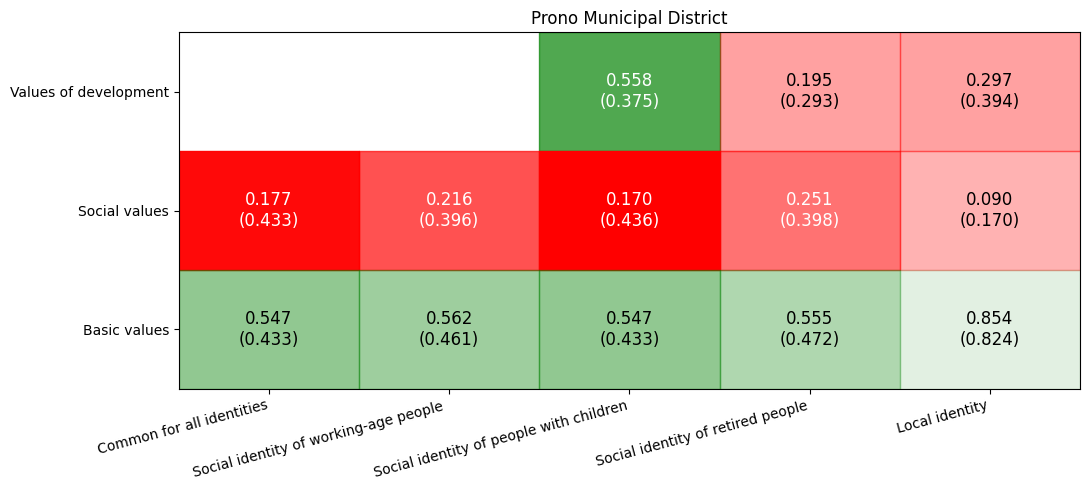

In [54]:
means = {}
for col in ['comm', 'soc_workers', 'soc_old', 'soc_parents', 'loc']:
    for row in ['dev', 'soc', 'base']:
        row_name = 'bas' if row == 'base' else row
        column_name = f'{col}_{row}'
        means[(row_name, col)] = nlo_tab[column_name].mean()

column_names = {
    'comm': 'Common for all identities',
    'soc_workers': 'Social identity of working-age people ',
    'soc_old': 'Social identity of people with children',
    'soc_parents': 'Social identity of retired people',
    'loc': 'Local identity'
}

row_names = {
    'dev': 'Values of development',
    'soc': 'Social values',
    'bas': 'Basic values'
}

sb_tab_renamed = sb_tab.copy()
sb_tab_renamed.index = [row_names[i] for i in sb_tab.index]
sb_tab_renamed.columns = [column_names[c] for c in sb_tab.columns]

values = np.zeros_like(sb_tab_renamed, dtype=float)
annotations = np.empty_like(sb_tab_renamed, dtype=object)
colors = np.empty_like(sb_tab_renamed, dtype=object)

max_diff = 0

for i, orig_i in zip(sb_tab_renamed.index, sb_tab.index):
    for j, orig_j in zip(sb_tab_renamed.columns, sb_tab.columns):
        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            val = sb_tab.loc[orig_i, orig_j]
            mean_val = means[(orig_i, orig_j)]
            diff = abs(val - mean_val)
            max_diff = max(max_diff, diff)

def get_color(val, mean_val, max_diff):
    diff = val - mean_val
    intensity = min(abs(diff) / max_diff, 1.0)
    if diff >= 0:
        return mcolors.to_rgba('green', intensity)
    else:
        return mcolors.to_rgba('red', intensity)

for i, orig_i in zip(sb_tab_renamed.index, sb_tab.index):
    for j, orig_j in zip(sb_tab_renamed.columns, sb_tab.columns):
        idx_i = sb_tab_renamed.index.get_loc(i)
        idx_j = sb_tab_renamed.columns.get_loc(j)

        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            val = sb_tab.loc[orig_i, orig_j]
            mean_val = means[(orig_i, orig_j)]
            values[idx_i, idx_j] = val
            annotations[idx_i, idx_j] = f'{val:.3f}\n({mean_val:.3f})'
            colors[idx_i, idx_j] = get_color(val, mean_val, max_diff)
        else:
            values[idx_i, idx_j] = np.nan
            annotations[idx_i, idx_j] = 'NaN'
            colors[idx_i, idx_j] = mcolors.to_rgba('white', 1.0)

plt.figure(figsize=(11, 5))

for i in range(len(sb_tab_renamed.index)):
    for j in range(len(sb_tab_renamed.columns)):
        if not np.isnan(values[i, j]):
            plt.fill_between([j, j+1], [i, i], [i+1, i+1], color=colors[i, j])
            plt.text(j + 0.5, i + 0.5, annotations[i, j],
                    ha='center', va='center',fontsize=12,
                    color='black' if mcolors.to_rgba(colors[i, j])[3] < 0.5 else 'white')

plt.ylim(len(sb_tab_renamed.index), 0)
plt.xlim(0, len(sb_tab_renamed.columns))
plt.xticks(np.arange(len(sb_tab_renamed.columns)) + 0.5, sb_tab_renamed.columns, rotation=15, ha='right')
plt.yticks(np.arange(len(sb_tab_renamed.index)) + 0.5, sb_tab_renamed.index)

plt.title('Prono Municipal District')
plt.tight_layout()
plt.show()

## Another one

In [55]:
result_norm = result[(result.year ==2022)]

In [56]:
result_norm.loc[result_norm['name'] == 'Гатчинский муниципальный район', 'parks'] = 3 / result_norm.loc[result_norm['name'] == 'Гатчинский муниципальный район', 'popsize']
result_norm.loc[result_norm['name'] == 'Гатчинский муниципальный район', 'theatres'] = 6 / result_norm.loc[result_norm['name'] == 'Гатчинский муниципальный район', 'popsize']

In [57]:
columns_to_normalize = [col for col in result_norm.columns if col not in ['oktmo', 'year','ydel_saldo','name' ]]

result_norm[columns_to_normalize] = (result_norm[columns_to_normalize] - result_norm[columns_to_normalize].min()) / (result_norm[columns_to_normalize].max() - result_norm[columns_to_normalize].min())


def calculate_loc_counts(row):
    loc_data = loc_counts(row, grid_coeffs)
    loc_series = tab_to_ser(loc_data, row.name)
    loc_series['oktmo'] = row['oktmo']
    loc_series['year'] = row['year']
    loc_series['ydel_saldo'] = row['ydel_saldo']
    return loc_series

full_df = result_norm.apply(calculate_loc_counts, axis=1)
full_df['year'] = pd.to_numeric(full_df['year'], errors='coerce').astype('Int64')
full_df['oktmo'] = pd.to_numeric(full_df['oktmo'], errors='coerce').astype('Int64')

rez = result_norm
rez['year'] = pd.to_numeric(rez['year'], errors='coerce').astype('Int64')
rez['oktmo'] = pd.to_numeric(rez['oktmo'], errors='coerce').astype('Int64')
rez=rez[(rez.oktmo >= 41000000) & (rez.oktmo < 42000000)]

lo_tab = full_df[(full_df.oktmo >= 41000000) & (full_df.oktmo < 42000000)& (full_df.year ==2022)]

columns_to_normalize = [col for col in lo_tab.columns if col not in ['oktmo', 'year','ydel_saldo' ]]


nlo_tab = lo_tab.copy()
nlo_tab[columns_to_normalize] = nlo_tab[columns_to_normalize].apply(lambda s: (s - s.min()) / (s.max() - s.min()), axis=0)


def color_cols_custom(s):

    if s.name in ['oktmo', 'year','ydel_saldo']:
        return [''] * len(s)

    better = s >= s.mean()
    return ['background-color: green' if v else 'background-color: red' for v in better]

nlo_tab.style.apply(color_cols_custom, axis=0)


C:\Users\user\AppData\Local\Temp\ipykernel_3748\2611301042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_norm[columns_to_normalize] = (result_norm[columns_to_normalize] - result_norm[columns_to_normalize].min()) / (result_norm[columns_to_normalize].max() - result_norm[columns_to_normalize].min())
C:\Users\user\AppData\Local\Temp\ipykernel_3748\2611301042.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez['year'] = pd.to_numeric(rez['year'], errors='coerce').astype('Int64')
C:\Users\user\A

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base,oktmo,year,ydel_saldo
9277,nan,nan,0.396249,0.804797,0.459927,0.293420,0.132459,0.302338,0.132459,0.463213,0.906249,0.997775,0.906249,0.995778,0.857057,41603000,2022,0.001258
9285,nan,nan,0.018292,0.494171,0.386138,0.316841,0.092007,0.313510,0.092007,0.733879,0.779545,0.818551,0.779545,0.870726,0.891013,41606000,2022,0.005206
9294,nan,nan,0.057206,0.611994,0.372991,0.542544,0.222157,0.547751,0.222157,0.334137,0.510873,0.595121,0.510873,0.588414,1.000000,41609000,2022,-0.000850
9302,nan,nan,0.128365,0.000000,0.116934,0.333764,0.474019,0.330399,0.474019,0.000000,0.258153,0.289439,0.258153,0.487345,0.814753,41612000,2022,0.079370
9311,nan,nan,0.011221,0.021385,0.382768,0.216085,0.322048,0.216271,0.322048,0.126765,0.000000,0.000000,0.000000,0.022104,0.683215,41615000,2022,0.001940
9320,nan,nan,0.013581,0.150753,0.149353,0.257098,0.367970,0.254245,0.367970,0.381906,0.541429,0.603922,0.541429,0.674976,0.877352,41618000,2022,0.000769
9329,nan,nan,0.350077,0.757516,0.427561,1.000000,1.000000,1.000000,1.000000,0.445907,1.000000,0.877482,1.000000,0.955577,1.000000,41621000,2022,-0.001972
9337,nan,nan,0.012665,0.567636,0.473075,0.915056,0.633933,0.911476,0.633933,0.468316,0.942316,0.946254,0.942316,0.948103,0.969646,41624000,2022,-0.006352
9346,nan,nan,0.033006,0.188979,0.000000,0.000000,0.277285,0.000000,0.277285,0.201008,0.536978,0.448762,0.536978,0.476424,0.890980,41625000,2022,0.001894
9355,nan,nan,0.096191,0.823608,0.360385,0.291089,0.000000,0.297694,0.000000,1.000000,0.121621,0.062980,0.121621,0.000000,0.684901,41627000,2022,0.003350


In [58]:
rez[(rez.name=='Гатчинский муниципальный район')]

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,hospitals,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,badhousesdwellers,litstreetperc
9320,41618000,2022,Гатчинский муниципальный район,0.005284,NaN,NaN,NaN,NaN,NaN,0.290845,...,0.144593,0.00684,0.00502,0.140742,0.113026,0.053814,0.074873,0.000769,0.019099,0.869274


In [59]:
nlo_tab = nlo_tab[nlo_tab.columns.drop(['ydel_saldo','oktmo', 'year'])]
sb_tab = loc_counts(rez.loc[9320], grid_coeffs)
sb = nlo_tab.loc[9320]

for i in sb_tab.index:
    # Replace 'bas' with 'base'
    row_name = 'base' if i == 'bas' else i
    for j in sb_tab.columns:
        sb_tab.loc[i, j] = sb.loc[f'{j}_{row_name}']

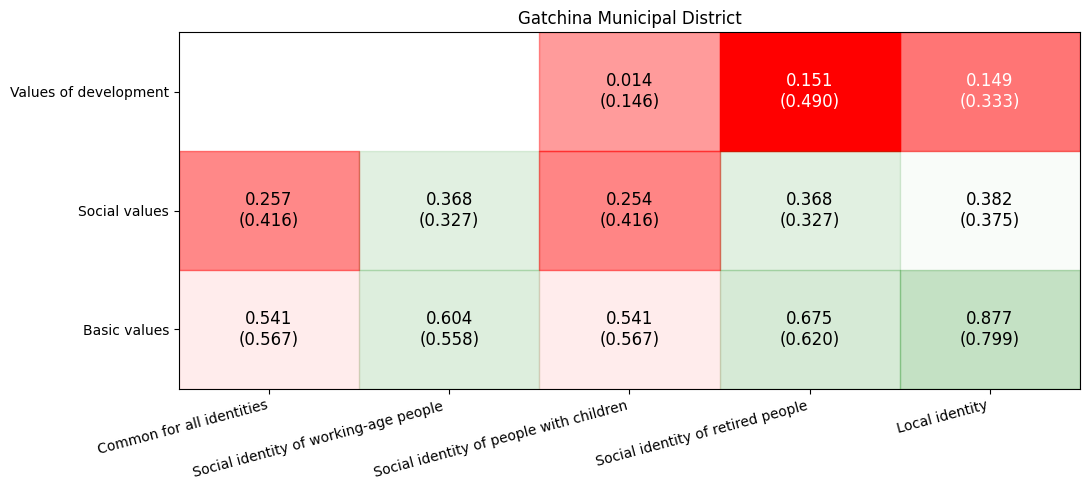

In [60]:
means = {}
for col in ['comm', 'soc_workers', 'soc_old', 'soc_parents', 'loc']:
    for row in ['dev', 'soc', 'base']:

        row_name = 'bas' if row == 'base' else row
        column_name = f'{col}_{row}'
        means[(row_name, col)] = nlo_tab[column_name].mean()

column_names = {
    'comm': 'Common for all identities',
    'soc_workers': 'Social identity of working-age people ',
    'soc_old': 'Social identity of people with children',
    'soc_parents': 'Social identity of retired people',
    'loc': 'Local identity'
}

row_names = {
    'dev': 'Values of development',
    'soc': 'Social values',
    'bas': 'Basic values'
}

sb_tab_renamed = sb_tab.copy()
sb_tab_renamed.index = [row_names[i] for i in sb_tab.index]
sb_tab_renamed.columns = [column_names[c] for c in sb_tab.columns]

values = np.zeros_like(sb_tab_renamed, dtype=float)
annotations = np.empty_like(sb_tab_renamed, dtype=object)
colors = np.empty_like(sb_tab_renamed, dtype=object)

max_diff = 0

for i, orig_i in zip(sb_tab_renamed.index, sb_tab.index):
    for j, orig_j in zip(sb_tab_renamed.columns, sb_tab.columns):
        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            val = sb_tab.loc[orig_i, orig_j]
            mean_val = means[(orig_i, orig_j)]
            diff = abs(val - mean_val)
            max_diff = max(max_diff, diff)

def get_color(val, mean_val, max_diff):
    diff = val - mean_val
    intensity = min(abs(diff) / max_diff, 1.0)
    if diff >= 0:
        return mcolors.to_rgba('green', intensity)
    else:
        return mcolors.to_rgba('red', intensity)

for i, orig_i in zip(sb_tab_renamed.index, sb_tab.index):
    for j, orig_j in zip(sb_tab_renamed.columns, sb_tab.columns):
        idx_i = sb_tab_renamed.index.get_loc(i)
        idx_j = sb_tab_renamed.columns.get_loc(j)

        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            val = sb_tab.loc[orig_i, orig_j]
            mean_val = means[(orig_i, orig_j)]
            values[idx_i, idx_j] = val
            annotations[idx_i, idx_j] = f'{val:.3f}\n({mean_val:.3f})'
            colors[idx_i, idx_j] = get_color(val, mean_val, max_diff)
        else:
            values[idx_i, idx_j] = np.nan
            annotations[idx_i, idx_j] = 'NaN'
            colors[idx_i, idx_j] = mcolors.to_rgba('white', 1.0)

plt.figure(figsize=(11, 5))

for i in range(len(sb_tab_renamed.index)):
    for j in range(len(sb_tab_renamed.columns)):
        if not np.isnan(values[i, j]):
            plt.fill_between([j, j+1], [i, i], [i+1, i+1], color=colors[i, j])
            plt.text(j + 0.5, i + 0.5, annotations[i, j],
                    ha='center', va='center', fontsize=12,
                    color='black' if mcolors.to_rgba(colors[i, j])[3] < 0.5 else 'white')

plt.ylim(len(sb_tab_renamed.index), 0)
plt.xlim(0, len(sb_tab_renamed.columns))
plt.xticks(np.arange(len(sb_tab_renamed.columns)) + 0.5, sb_tab_renamed.columns, rotation=15, ha='right')
plt.yticks(np.arange(len(sb_tab_renamed.index)) + 0.5, sb_tab_renamed.index)

plt.title('Gatchina Municipal District')
plt.tight_layout()
plt.show()